# Python Tutorial Seminar Series: Cartopy (4/28) #

This tutorial will cover the basics of Cartopy including: coordinate systems, map masking, map projection options, and Cartopy's many applications with geospatial data. We will also discuss best practices when it comes to choosing a colormap color scheme.

## 1. Import necessary packages and read in data ##
We will read in a couple different datasets here, but will use them in different examples throughout this tutorial. When a new dataset is being used, it will be marked clearly in the comments of the applicable code block.

You will notice the "GeoCAT Specific Packages" below. These packages allow us to have a whole repository or datafiles without explicitly downloading them to your computer and offer some plotting/visualization convenience functions that are used later in this file. If you would like to learn more about the GeoCAT project, which includes a [Python plotting example library](https://geocat-examples.readthedocs.io/en/latest/), please visit the [GeoCAT project homepage](https://geocat.ucar.edu/pages/software.html).

In [8]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

#GeoCAT Specific packages
from geocat.viz import util as gvutil
import geocat.datafiles as gdf

# Read in datasets using xarray and netCDF4
res = xr.open_dataset(gdf.get("netcdf_files/tpom000.partial.nc")) # Resolution example 
atmos = xr.open_dataset(gdf.get("netcdf_files/atmos.nc"), decode_times=False) # Zooming and Masking example 

## 2. Create a basic map projection using Cartopy ##
To start things off, we will create a very basic map projection that does not use any data. This is to serve as a warm up for the tutorial and help familiarize you with the Cartopy package. We will use the Cartopy feature interface (cfeature) to add geographic features like bodies of water, borders, and coastlines. We will also add latitude and longitude gridlines to this projection.

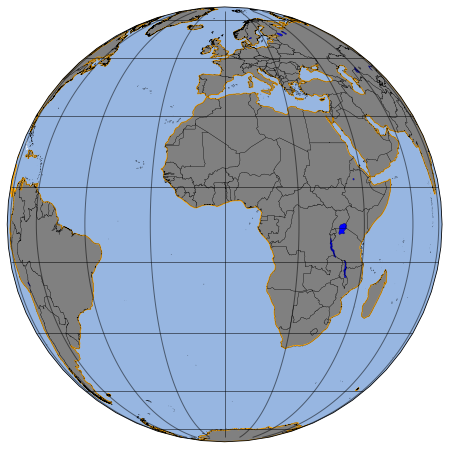

In [30]:
# Create and define the size of a figure object 
plt.figure(figsize=(8, 8))

# Create an axis with an basic PlateCarree projection style
ax = plt.axes(projection=ccrs.Orthographic())

# Use different map projections 


# Add natural features to map using cartopy.feature (cfeature)
ax.add_feature(cfeature.LAND, edgecolor='orange', facecolor='grey', zorder=0)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='blue')
ax.add_feature(cfeature.OCEAN)

# Add border lines over countries 
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))


# Add lat/lon gridlines
# Draw gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5)

# Manipulate latitude and longitude gridline numbers and spacing
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20))
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))

# For a list of available features in NaturalEarthFeature visit: https://www.naturalearthdata.com/features/

## 3. Change resolution of projection features ##
Using dataset 'res', we will experiment with the different resolution options in Cartopy. We will also implement a color scheme that follows best practices for being more colorblind friendly. For more information on these practices, please refer to the GeoCAT-examples library 'colors' section found here: https://geocat-examples.readthedocs.io/en/latest/gallery/index.html#colors

We will also discuss the differences between 'transform' and 'projection' in cartopy. The primary difference is that 'projection' only tells Python what map we want to see. 'transform' tells Python what coordinate reference system our data is using. More information and examples on this difference can be found on the [Cartopy website](https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html).

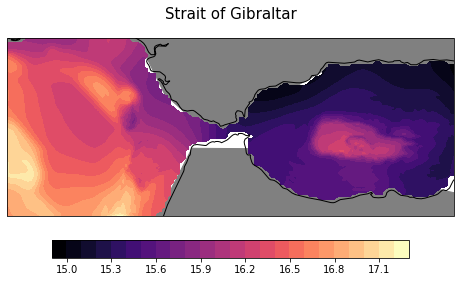

In [21]:
# Extract a specific time 'slice' of data
t = res.t

# Create a figure object
fig = plt.figure(figsize=(8, 6))

# Generate axes, using Cartopy, drawing coastlines, and adding features
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines('10m')
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='grey')
# Contourf-plot data
temp = t.plot.contourf(ax=ax,
                      transform=proj, # What is the difference between 'transform' and 'projection'?
                      levels=25,
                      vmin=14.9,
                      vmax=17.3,
                      cmap='magma', # Using best practices when choosing a colormap color scheme
                      add_colorbar=False)

cbar_ticks = np.arange(15, 17.3, 0.3)
cbar = plt.colorbar(temp,
                    orientation='horizontal',
                    shrink=0.8,
                    pad=0.073,
                    extendrect=True,
                    ticks=cbar_ticks)

cbar.ax.tick_params(labelsize=10)

# Add a title to the map projection
plt.title('Strait of Gibraltar', x=.5, y=1.07, fontsize=15)
plt.show()


# Now try with the other two resolutions '50m' and '110m'

## 4. Zoom into a specific area on a map ##
For this example, we will 'zoom' into a specific location on the map. Zooming in cartopy is essentially just subsetting your dataset on your axes object. If your dataset encompassed -180W to 180E latitude and -90S to 90N longitude, a 'zoom' into, say, -100W to -95W and -45S to 45N, you would be telling Python to ignore any data points outside of that specified range. This would then effectively 'zoom' into that defined box on the map and not show the other data points in the data set.

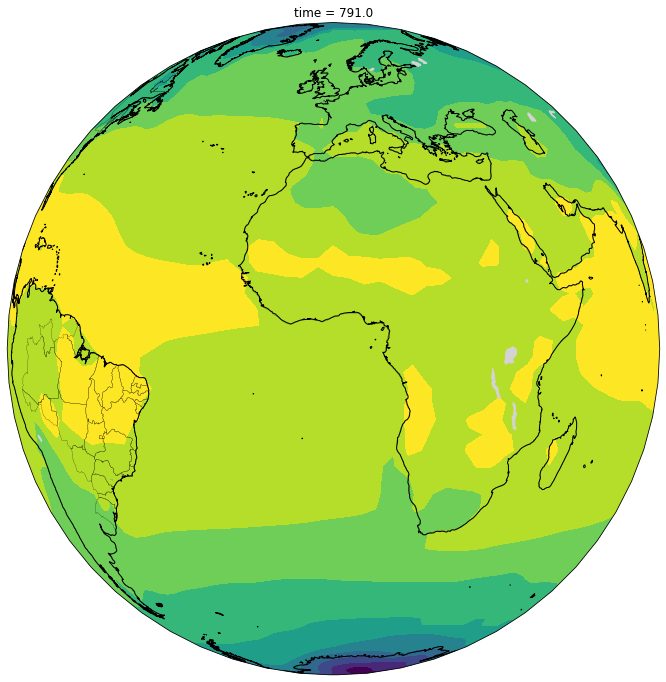

In [32]:
# Select a slice of the dataset
t = atmos.TS.isel(time=0)

# Use a GeoCAT-viz function to fix the artifact of not-shown-data around 0 and 360-degree longitudes
t = gvutil.xr_add_cyclic_longitudes(t, "lon")

# Create a figure object and generate axes
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.Orthographic())

# Add features to the projection
ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black', linewidth=0.2, zorder=3)

states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=0.2)


# Note: This is the same process as turning your projection argument into a variable and calling it later. This may
# not be the most time saving practice for this example, but if this feature were being reused multiple times in a
# single code, this method would come in handy.

# Add coastlines to the projection and define resolution based on resolution previously used
ax.coastlines('50m')
ax.add_feature(states)

# Add filled dew point temperature contours
t.plot.contourf(ax=ax,
                     transform=ccrs.PlateCarree(),
                     levels=12,
                     cmap='viridis', # Another best practice color scheme
                     add_colorbar=False)

# Zoom into a specific area on the map 
#ax.set_extent((-130, -110, 25, 45), crs=ccrs.PlateCarree())

# Add another feature to your map 
ax.add_feature(cfeature.LAKES, facecolor='lightgrey')


## 5. Mask a map projection ##
In this example, we will 'mask' a Cartopy map projection with data from our dataset. This allows us to, essentially, block out specific areas of data on the projection. 

Text(0.5, 1.0, 'No mask, data only')

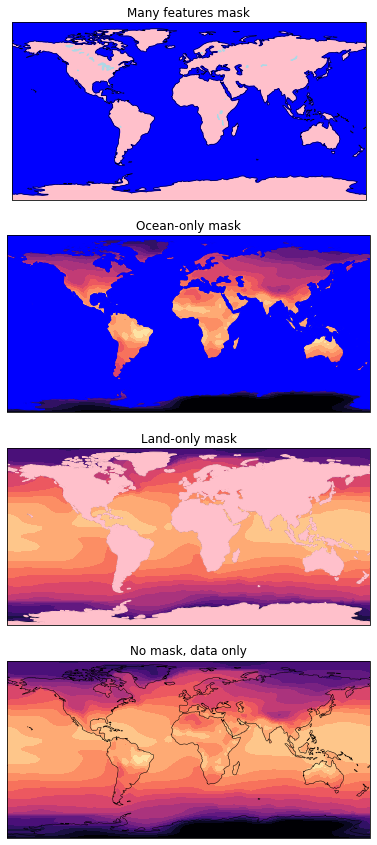

In [27]:
# Select a slice of the dataset
t = atmos.TS.isel(time=0)

# Use a GeoCAT-viz function to fix the artifact of not-shown-data around 0 and 360-degree longitudes
t = gvutil.xr_add_cyclic_longitudes(t, "lon")

# Create a figure object
fig = plt.figure(figsize=(10, 15))

# Plot first plot
# Generate axes using Cartopy and draw coastlines
proj = ccrs.PlateCarree()
ax = plt.subplot(4, 1, 1, projection=proj)
ax.coastlines(linewidths=0.5)

# Lets mask out a couple of the features in this projection
# Mask land
ax.add_feature(cfeature.LAND, facecolor='pink')
# Mask lakes
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
# Mask oceans
ax.add_feature(cfeature.OCEAN, facecolor='blue')

plt.title("Many features mask")

# Plot second plot
ax1 = plt.subplot(4, 1, 2, projection=proj)
ax1.coastlines(linewidths=0.5)

# Contourf-plot data
t.plot.contourf(ax=ax1,
               transform=proj,
               vmin=235,
               vmax=315,
               levels=18,
               cmap='magma',
               add_colorbar=False)


# Mask ocean data by adding ocean feature and changing its zorder
ax1.add_feature(cfeature.OCEAN, facecolor='blue', zorder=1)

plt.title("Ocean-only mask")

# Plot third plot
ax2 = plt.subplot(4, 1, 3, projection=proj)
ax2.coastlines(linewidths=0.5)

# Contourf-plot data
t.plot.contourf(ax=ax2,
               transform=proj,
               vmin=235,
               vmax=315,
               levels=18,
               cmap='magma',
               add_colorbar=False)


# Mask land data by adding land feature and changing its zorder
ax2.add_feature(cfeature.LAND, facecolor='pink', zorder=1)

plt.title("Land-only mask")

# Plot fourth plot
ax3 = plt.subplot(4, 1, 4, projection=proj)
ax3.coastlines(linewidths=0.5)

# Contourf-plot data
t.plot.contourf(ax=ax3,
               transform=proj,
               vmin=235,
               vmax=315,
               levels=18,
               cmap='magma',
               add_colorbar=False)

plt.title("No mask, data only")

## Put it all together and try it yourself! ##

Try to make a map projection of your choice that features the three things we just covered:
1. Map resolution
2. Zooming in on data
3. Masking a specific feature out 

We are going to use the same dataset from the last example, which has already been called in for you. Follow along with me, or try by yourself!

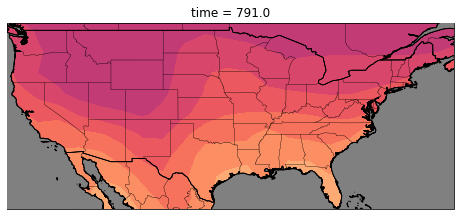

In [29]:
# Select a slice of the dataset
t = atmos.TS.isel(time=0)

# Use a GeoCAT-viz function to fix the artifact of not-shown-data around 0 and 360-degree longitudes
t = gvutil.xr_add_cyclic_longitudes(t, "lon")

# Create a figure object
fig = plt.figure(figsize=(8,6))

# Generate axes using Cartopy
ax =plt.axes(projection=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Add state borders
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_1_states_provinces_shp',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))

# Add country borders 
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.8))

# Add ocean mask
ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=5, edgecolor='black', facecolor='grey')

# Overlay data using contourf
t.plot.contourf(ax=ax,
               transform=ccrs.PlateCarree(),
               vmin=235,
               vmax=315,
               levels=18,
               cmap='magma',
               add_colorbar=False)

# Zoom into a specific area 
ax.set_extent((-125, -65, 25, 50), crs=ccrs.PlateCarree())

